# Implementação de métodos de detecção de picos em séries temporais

Baseado nos métodos propostos em "Simple Algorithms for Peak Detection in Time-Series" (Girish Palshikar, 2009).

In [7]:
# Bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import importlib
import scienceplots
from sklearn.preprocessing import normalize
from IPython.display import clear_output
import sys

# Funções utilitárias
#
# Adiciona o caminho para a pasta em que os arquivos utilitários estão
sys.path.insert(1, '/home/yanvgf/Projetos/litc/ihm/previsao-flotacao/novos-dados/git-workspace/Fase3')
#
import Utils.NomesDasVariaveis
import Utils.pre_processing
import Utils.models
import Utils.analysis

# Atualiza bibliotecas sem precisar reiniciar o kernel
importlib.reload(Utils.NomesDasVariaveis)
importlib.reload(Utils.pre_processing)
importlib.reload(Utils.analysis)
importlib.reload(Utils.models)

# Configuração dos plots
plt.style.use(['grid', 'notebook', 'science'])
plt.rcParams["figure.figsize"] = (10,6)

In [8]:
# SAÍDAS
saidas_L1 = ['4_ALZ1VI_QQ_GLOBAL_SiO2', '4_ALZ1VI_QQ_GLOBAL_Fe', '4_RJT1VI_QQ_GLOBAL_Fe']
saidas_L2 = ['4_ALZ2VI_QQ_GLOBAL_SiO2', '4_ALZ2VI_QQ_GLOBAL_Fe', '4_RJT2VI_QQ_GLOBAL_Fe']

# SELECIONE A SAÍDA AQUI
target = saidas_L1[0]

## Funções criadas

In [9]:
def s1_metric(data, k):
    """Métrica S1 do artigo (média entre a máxima distância de um ponto até seus k vizinhos à direita e a máxima à esquerda)

    Input:
        data (pd.DataFrame): dataframe com os dados a serem classificados em pico ou não\n
        k (int): número de vizinhos a ser considerado (no artigo, é sugerido utilizar um valor com sentido, ex.: amostras referentes a 1 dia)\n
    
    Output:
        s1 (pd.DataFrame): série com os valores da métrica S1 para cada ponto
    """
    
    s1 = np.zeros(data.shape[0])
    
    # Para cada amostra em data, calcula a diferença entre seu valor e seus k vizinhos à direita e à esquerda
    for idx in range(data.shape[0]):
        max_right = np.max([data.iloc[idx,:].values[0] - data.iloc[idx+k_i+1,:].values[0]
                        if idx+k_i+1 < data.shape[0] else 0
                        for k_i in range(k)])
        max_left = np.max([data.iloc[idx,:].values[0] - data.iloc[idx-(k_i+1),:].values[0] 
                        if idx-(k_i+1) >= 0 else 0
                        for k_i in range(k)])
        s1[idx] = (max_right + max_left)/2
        
    return pd.DataFrame(s1)

####################################################################################################

def s2_metric(data, k):
    """Métrica S2 do artigo (média entre a distância média de um ponto até seus k vizinhos à direita e a máxima à esquerda)

    Input:
        data (pd.DataFrame): dataframe com os dados a serem classificados em pico ou não\n
        k (int): número de vizinhos a ser considerado (no artigo, é sugerido utilizar um valor com sentido, ex.: amostras referentes a 1 dia)\n
    
    Output:
        s2 (pd.DataFrame): série com os valores da métrica S2 para cada ponto
    """
    
    s2 = np.zeros(data.shape[0])
    
    # Para cada amostra em data, calcula a diferença entre seu valor e seus k vizinhos à direita e à esquerda
    for idx in range(data.shape[0]):
        mean_right = np.mean([data.iloc[idx,:].values[0] - data.iloc[idx+k_i+1,:].values[0]
                            if idx+k_i+1 < data.shape[0] else 0
                            for k_i in range(k)])
        mean_left = np.mean([data.iloc[idx,:].values[0] - data.iloc[idx-(k_i+1),:].values[0] 
                            if idx-(k_i+1) >= 0 else 0
                            for k_i in range(k)])
        s2[idx] = (mean_right + mean_left)/2
        
    return pd.DataFrame(s2)

####################################################################################################

def s3_metric(data, k):
    """Métrica S3 do artigo (média entre a distância média de um ponto até o ponto médio de seus k vizinhos à direita e a máxima à esquerda)

    Input:
        data (pd.DataFrame): dataframe com os dados a serem classificados em pico ou não\n
        k (int): número de vizinhos a ser considerado (no artigo, é sugerido utilizar um valor com sentido, ex.: amostras referentes a 1 dia)\n
    
    Output:
        S3 (pd.DataFrame): série com os valores da métrica S3 para cada ponto
    """
    
    s3 = np.zeros(data.shape[0])
    
    # Para cada amostra em data, calcula a diferença entre seu valor e seus k vizinhos à direita e à esquerda
    for idx in range(data.shape[0]):
        diff_right = data.iloc[idx,:].values[0] - np.mean([data.iloc[idx+k_i+1,:].values[0]
                                                        if idx+k_i+1 < data.shape[0] else 0
                                                        for k_i in range(k)])
        diff_left = data.iloc[idx,:].values[0] - np.mean([data.iloc[idx-(k_i+1),:].values[0] 
                                                        if idx-(k_i+1) >= 0 else 0
                                                        for k_i in range(k)])
        s3[idx] = (diff_right + diff_left)/2
        
    return pd.DataFrame(s3)

# Teste em dados reais

In [10]:
# Dados de treino
train_RD = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/RD_train_{target}.csv')

# Dados de teste
test_RD = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/RD_test_{target}.csv')
target_test = pd.DataFrame(test_RD[target])

In [11]:
# Dataset completo
full_dataset_train = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/full_train_{target}.csv')
full_dataset_test = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/full_test_{target}.csv')

# Dataset apenas com duplicatas removidas, siConL1
train_RD = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/RD_train_{target}.csv')
test_RD = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/RD_test_{target}.csv')

# Vou manter as datas do conjunto de dados para facilitar a organização após a seleção de amostras
index_train = train_RD.iloc[:,0]
train_RD = train_RD.iloc[:,1:]
index_test = test_RD.iloc[:,0]
test_RD = test_RD.iloc[:,1:]

# Renomeando e transformando coluna de datas em index dos dataframes
#
# Treinamento
reference_points = train_RD
reference_points.index = np.array([datetime.strptime(data_str, '%Y-%m-%d %H:%M:%S') for data_str in index_train])
#
full_train_time, full_dataset_train = (full_dataset_train[full_dataset_train.columns.values[0]], full_dataset_train[full_dataset_train.columns.values[1:]])
full_train_time = pd.to_datetime(full_train_time.values)
full_dataset_train.index = full_train_time
#
# Teste
test_points = test_RD
test_points.index = np.array([datetime.strptime(data_str, '%Y-%m-%d %H:%M:%S') for data_str in index_test])
#
full_test_time, full_dataset_test = (full_dataset_test[full_dataset_test.columns.values[0]], full_dataset_test[full_dataset_test.columns.values[1:]])
full_test_time = pd.to_datetime(full_test_time.values)
full_dataset_test.index = full_test_time

# Separação das variáveis em variáveis químicas em variáveis de processo
var2h, var1min = Utils.NomesDasVariaveis.getVariablesNames(full_dataset_train)
var2h = list(set(var2h).intersection(set(full_dataset_train.columns.values)))

não há Data_Fim
não há Unnamed: 0


In [12]:
# Calcula as métricas S1, S2 e S3 para o conjunto de teste
#
# k = 6 porque as amostras são coletadas de 2h em 2h, então consigo comparar cada amostra com o dia em que ela foi coletada
k = 30
s1_test = s1_metric(target_test, k)
s2_test = s2_metric(target_test, k)
s3_test = s3_metric(target_test, k)

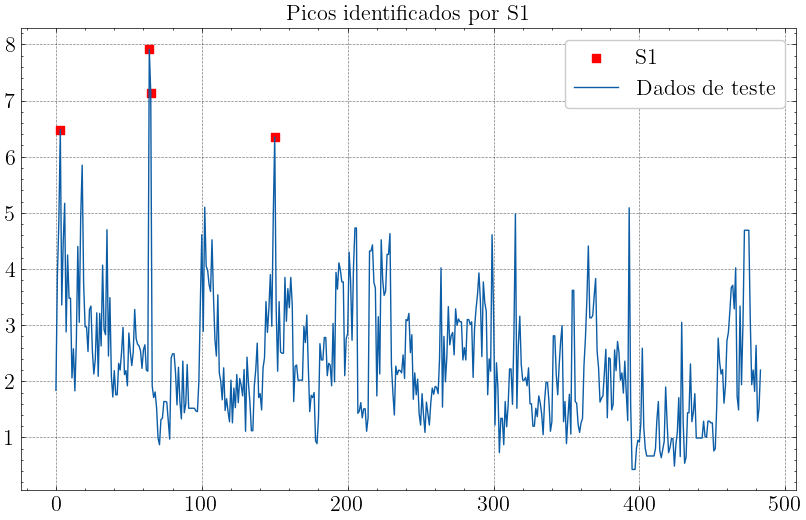

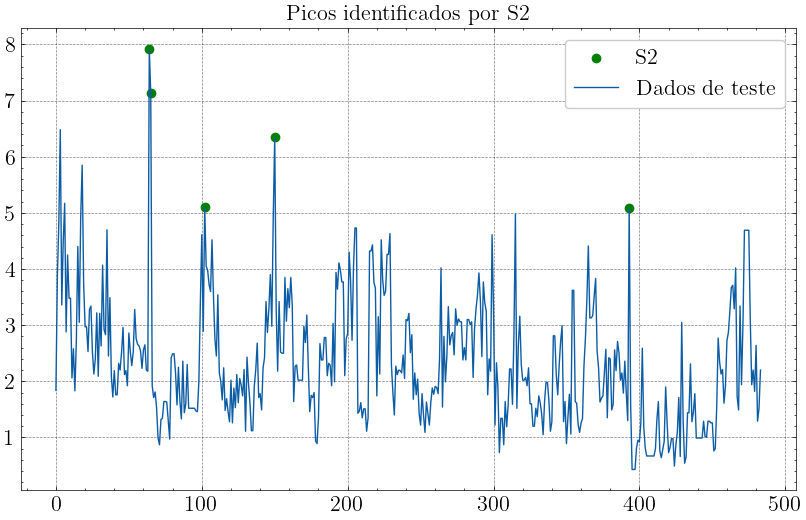

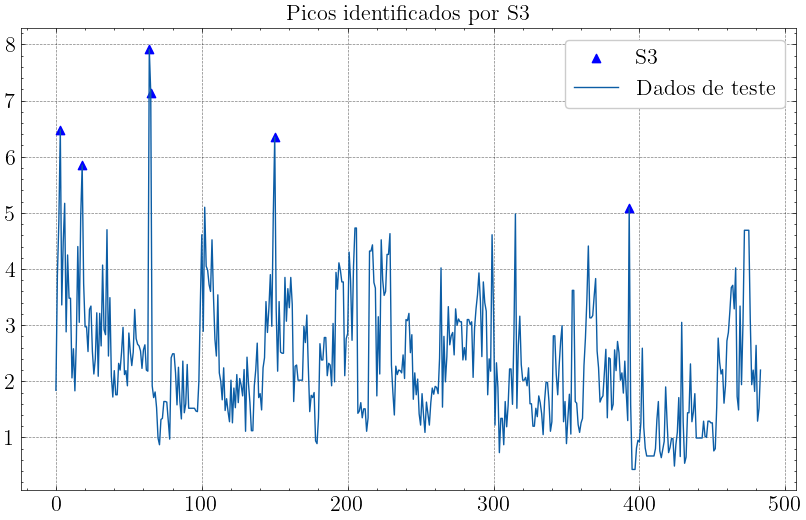

In [28]:
# Calcula média e desvio padrão de S1
s1_test_mean = np.mean(s1_test, axis=0)
s1_test_std = np.std(s1_test)
#
# Calcula média e desvio padrão de S2
s2_test_mean = np.mean(s2_test, axis=0)
s2_test_std = np.std(s2_test)
#
# Calcula média e desvio padrão de S3
s3_test_mean = np.mean(s3_test, axis=0)
s3_test_std = np.std(s3_test)


# Obtém índices dos picos (3 desvios padrão acima da média)
#
# S1
s1_is_peak = np.where(s1_test > s1_test_mean + 3*s1_test_std, True, False)
s1_peak_indexes = [i for (i, value) in enumerate(s1_is_peak) if value]
#
# S2
s2_is_peak = np.where(s2_test > s2_test_mean + 3*s2_test_std, True, False)
s2_peak_indexes = [i for (i, value) in enumerate(s2_is_peak) if value]
#
# S3
s3_is_peak = np.where(s3_test > s3_test_mean + 3*s3_test_std, True, False)
s3_peak_indexes = [i for (i, value) in enumerate(s3_is_peak) if value]

# Marcar no gráfico os picos identificados por cada métrica
#
# S1
plt.scatter(s1_peak_indexes, target_test.values[s1_peak_indexes], marker='s', color='r', label='S1')
#
# Plotar gráfico com os picos identificados
plt.plot(target_test.values, label='Dados de teste')
plt.title(f'Picos identificados por S1')
plt.legend(frameon=True)
plt.show()

# S2
plt.scatter(s2_peak_indexes, target_test.values[s2_peak_indexes], marker='o', color='g', label='S2')
#
# Plotar gráfico com os picos identificados
plt.plot(target_test.values, label='Dados de teste')
plt.title(f'Picos identificados por S2')
plt.legend(frameon=True)
plt.show()

# S3
plt.scatter(s3_peak_indexes, target_test.values[s3_peak_indexes], marker='^', color='b', label='S3')
#
# Plotar gráfico com os picos identificados
plt.plot(target_test.values, label='Dados de teste')
plt.title(f'Picos identificados por S3')
plt.legend(frameon=True)
plt.show()

# Avaliação do modelo nos pontos identificados como picos

### 1. Obtenção do erro do modelo em toda a série

In [13]:
# Identificando todas as amostras válidas de treino e teste
sampling_dates_train = np.array([data for data in Utils.pre_processing.datetime64_to_datetime(pd.DataFrame(full_dataset_train.index.values)) if Utils.pre_processing.is_laboratory_sampling_time(data, minutes=1)])
sampling_dates_test = np.array([data for data in Utils.pre_processing.datetime64_to_datetime(pd.DataFrame(full_dataset_test.index.values)) if Utils.pre_processing.is_laboratory_sampling_time(data, minutes=1)])

# Obtém início e fim de períodos contínuos
continuous_train = Utils.pre_processing.get_continuous_windows(pd.DataFrame(sampling_dates_train),
                                                                sampling_scale='hours',
                                                                sampling_gap=2)
# Obtém início e fim de períodos contínuos
continuous_test = Utils.pre_processing.get_continuous_windows(pd.DataFrame(sampling_dates_test),
                                                                sampling_scale='hours',
                                                                sampling_gap=2)

# Tratamento final (deslocamentos e interpolação, considerando as descontinuidades)
final_train_original = Utils.pre_processing.treat_discontinuities(full_dataset_train, 
                                                            continuous_train,
                                                            target,
                                                            pd.DataFrame(var2h),
                                                            data_shift=120,
                                                            interpolate=True,
                                                            get_naive=False)
final_test, naive = Utils.pre_processing.treat_discontinuities(full_dataset_test, 
                                                                continuous_test,
                                                                target,
                                                                pd.DataFrame(var2h),
                                                                data_shift=1,
                                                                interpolate=False,
                                                                get_naive=True)

Tamanho final do dataset: 98596 amostras


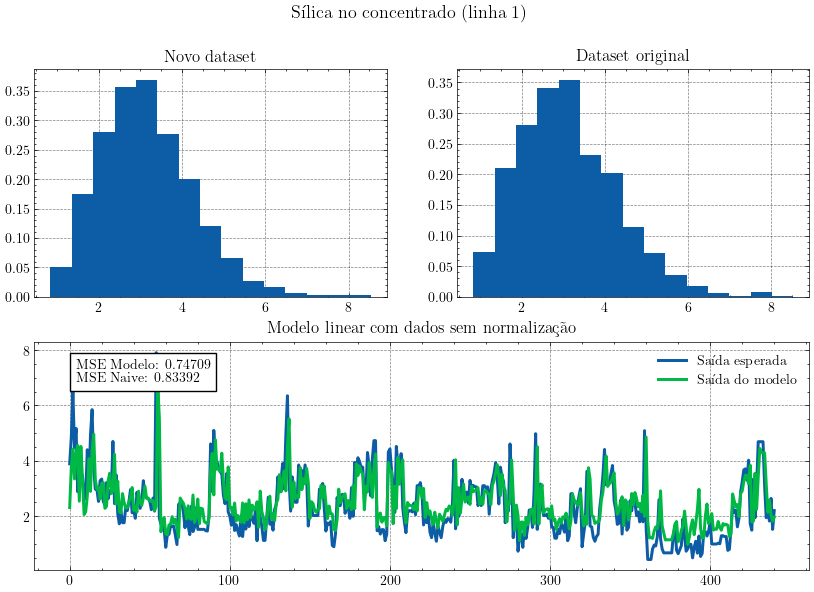

In [26]:
# Geração do modelo
yhat_original, mse_original, _ = Utils.models.adaline(final_train_original.loc[:,final_train_original.columns.values!=target].reset_index(drop=True),
                                        final_train_original.loc[:,target].reset_index(drop=True),
                                        final_test.loc[:,final_test.columns.values!=target].reset_index(drop=True),
                                        final_test.loc[:,target].reset_index(drop=True))

# Plot dos resultados
mse, mseNaive, pesosPerceptron = Utils.models.evaluate_model(final_train_original, final_test, train_RD, naive,
                                                       target, feature_set=final_train_original.columns,
                                                       norm=0, plot=1)

### 1. Obtenção do erro do modelo nos pontos identificados como pico

In [32]:
model_squared_error_series = (yhat_original.values.flatten() - final_test.loc[:,target].values.flatten())**2
naive_squared_error_series = (naive.values.flatten() - final_test.loc[:,target].values.flatten())**2

model_peak_mse = np.mean(model_squared_error_series[s3_peak_indexes])
naive_peak_mse = np.mean(naive_squared_error_series[s3_peak_indexes])

In [33]:
model_peak_mse

0.7746286099392069

In [34]:
naive_peak_mse

0.8296500425100031